In [1]:
from animalai.envs.arena_config import Vector3, RGB, Item, Arena, ArenaConfig
from animalai.envs.environment import AnimalAIEnvironment
from mlagents_envs.exception import UnityCommunicationException

from typing import List
from animalai.communicator_objects import (
    ArenasConfigurationsProto,
    ArenaConfigurationProto,
    ItemToSpawnProto,
    VectorProto,
)

from typing import List
import yaml
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import networkx as nx
from networkx import grid_graph

import gym
from random import randint

# PAIRED

In this section we create the gym environment as in PAIRED: https://github.com/google-research/google-research/blob/master/social_rl/gym_multigrid/envs/adversarial.py

In [4]:
class AdversarialEnv(gym.Env):
    ''' Grid world where an adversary build the environment the agent plays.
    The adversary places the goal, agent, and up to n_clutter blocks in sequence.
    The action dimension is the number of squares in the grid, and each action
    chooses where the next item should be placed. '''

    def __init__(self, n_clutter=10, size=40, goal_noise=0., random_z_dim=10, choose_goal_last=False):
        '''Initializes environment in which adversary places goal, agent, obstacles.
        Args:
          n_clutter: The maximum number of obstacles the adversary can place.
          size: The number of tiles across one side of the grid; i.e. make a size x size grid.
          max_steps: The maximum number of steps that can be taken before the episode terminates.
          goal_noise: The probability with which the goal will move to a different location than 
              the one chosen by the adversary.
          random_z_dim: The environment generates a random vector z to condition the adversary. 
              This gives the dimension of that vector.
          choose_goal_last: If True, will place the goal and agent as the last actions, rather than the first actions.
        '''
        # define params
        self.agent_start_pos = None
        self.goal_pos = None
        self.n_clutter = n_clutter
        self.goal_noise = goal_noise # we do not actualy use it (not yet)
        self.random_z_dim = random_z_dim
        self.choose_goal_last = choose_goal_last
        # Add two actions for placing the agent and goal.
        self.adversary_max_steps = self.n_clutter + 2
        self.width=size
        self.height=size
        
        self.reset_metrics()

        # Create spaces for adversary agent's specs: all spaces where it can place an object
        self.adversary_action_dim = size**2
        self.adversary_action_space = gym.spaces.Discrete(self.adversary_action_dim)
        self.adversary_ts_obs_space = gym.spaces.Box(
            low=0, high=self.adversary_max_steps, shape=(1,), dtype='uint8')
        self.adversary_randomz_obs_space = gym.spaces.Box(
            low=0, high=1.0, shape=(random_z_dim,), dtype=np.float32)
        # obs space: 0 if arena, 1 agent, 2 goal, walls 3
        self.adversary_image_obs_space = gym.spaces.Box(low=0,high=3,shape=(self.width, self.height, 1),dtype='uint8')

        # Adversary observations are dictionaries containing an encoding of the grid, the current time step, 
        # and a randomly generated vector used to condition generation (as in a GAN).
        self.adversary_observation_space = gym.spaces.Dict(
            {'image': self.adversary_image_obs_space,
             'time_step': self.adversary_ts_obs_space,
             'random_z': self.adversary_randomz_obs_space})

    def _gen_grid(self):
        """Grid is initially empty, because adversary will create it."""
        # Create an empty grid
        self.grid = np.zeros((self.width, self.height))
        
    def get_goal(self):
        if self.goal_pos is None:
            return -1
        return self.goal_pos[0]

    def get_agent(self):
        if self.goal_pos is None:
            return -1
        return self.agent_start_pos
    
    def reset_metrics(self):
        '''Define other metrics'''
        self.distance_to_goal = -1
        self.n_clutter_placed = 0
        self.deliberate_agent_placement = -1
        self.passable = -1
        self.adversary_step_count = 0
        self.graph = grid_graph(dim=[self.width, self.height])
        self.wall_locs = []
        
    def reset(self):
        '''Fully resets the environment to an empty grid with no agent or goal.'''
        
        self.adversary_step_count = 0

        self.agent_start_pos = None
        self.goal_pos = None

        # Extra metrics
        self.reset_metrics()

        # Generate the empty grid
        self._gen_grid()

        #image = self.grid.encode()
        obs = {
            'image': self.grid,
            'time_step': [self.adversary_step_count],
            'random_z': self.generate_random_z()
        }
        
        done = False

        return obs
    
    def generate_random_z(self):
        return np.random.uniform(size=(self.random_z_dim,)).astype(np.float32)
    
    def remove_wall(self, x, y):
        # if there is a wall, remove it
        if self.grid[x, y] == 3:
            self.grid[x, y] = 0
            
    def render(self):
        fig = plt.imshow(self.grid, cmap=plt.get_cmap('Accent'))
        # values
        values = np.array([0, 1, 2, 3])
        #items
        items = ['Arena', 'Agent', 'Goal', 'Wall']
        # colormap used by imshow
        colors = [fig.cmap(fig.norm(value)) for value in values]
        # create a patch (proxy artist) for every color 
        patches = [mpatches.Patch(color=colors[i], label="{l}".format(l=items[i]) ) for i in range(len(values)) ]
        # put those patched as legend-handles into the legend
        plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

        plt.grid(False)
        plt.show()
        
    def compute_shortest_path(self):
        if self.agent_start_pos is None or self.goal_pos is None:
            return

        self.distance_to_goal = abs(
            self.goal_pos[0] - self.agent_start_pos[0]) + abs(
                self.goal_pos[1] - self.agent_start_pos[1])

        # Check if there is a path between agent start position and goal. Remember
        # to subtract 1 due to outside walls existing in the Grid, but not in the
        # networkx graph.
        self.passable = nx.has_path(
            self.graph,
            source=(self.agent_start_pos[0], self.agent_start_pos[1]),
            target=(self.goal_pos[0], self.goal_pos[1]))
        if self.passable:
          # Compute shortest path
            self.shortest_path_length = nx.shortest_path_length(
              self.graph,
              source=(self.agent_start_pos[0], self.agent_start_pos[1]),
              target=(self.goal_pos[0], self.goal_pos[1]))
        else:
          # Impassable environments have a shortest path length 1 longer than
          # longest possible path
            self.shortest_path_length = (self.width - 1) * (self.height - 1) + 1
    
    def step(self, loc):
    #def step(self, x, y):
        '''The adversary gets n_clutter + 2 moves to place the goal, agent, blocks.
        The action space is the number of possible squares in the grid. 
        The squares are numbered from left to right, top to bottom.
        Args:
          loc: An integer specifying the location to place the next object which
            must be decoded into x, y coordinates.
        Returns:
          Standard RL observation, reward (always 0), done, and info
        '''
        #if loc >= self.adversary_action_dim:
         #   raise ValueError('Position passed to step_adversary is outside the grid.')

        x = int(loc % self.width) 
        y = int(loc / self.width) 
        #done = False
        
        # Check if we should choose goal or agent
        if self.choose_goal_last:
            should_choose_goal = self.adversary_step_count == self.adversary_max_steps - 2
            should_choose_agent = self.adversary_step_count == self.adversary_max_steps - 1
        else:
            should_choose_goal = self.adversary_step_count == 0
            should_choose_agent = self.adversary_step_count == 1
        
        if should_choose_goal:
            self.grid[x, y] = 1
            self.goal_pos = [x, y]
        elif should_choose_agent:
            if self.grid[x, y] != 1:
                self.grid[x, y] = 2
                self.agent_start_pos = [x, y]
            else:
                while self.grid[x, y] == 1:
                    x = randint(1, 14)
                    y = randint(1, 14)
                    self.grid[x, y] = 2
                    self.agent_start_pos = [x, y]           
        else:
            if self.grid[x, y] != 1 and self.grid[x, y] != 2:
                self.grid[x, y] = 3
                if (x, y) not in self.wall_locs:
                    self.wall_locs.append((x, y))
            
        self.adversary_step_count += 1
            
        # End of episode
        if self.adversary_step_count >= self.adversary_max_steps:
            done = True
            
            # Build graph after we are certain agent and goal are placed
            for w in self.wall_locs:
                self.graph.remove_node(w)
            self.compute_shortest_path()

        obs = {
            'image': self.grid,
            'time_step': [self.adversary_step_count],
            'random_z': self.generate_random_z()
        }

        #return obs, env.shortest_path_length  if done else 0, done, {}
        return obs, 0, done, {}

## more simple + inlcuding protagonist trainer

In [2]:
from utils import *

In [3]:
import gym
from gym.utils import seeding
import numpy as np
from random import randint

import networkx as nx
from networkx import grid_graph

class Adversarial_v2(gym.Env):
    ''' Grid world where an adversary build the environment the agent plays.
    The adversary places the goal, agent, and up to n_clutter blocks in sequence.
    The action dimension is the number of squares in the grid, and each action
    chooses where the next item should be placed. '''

    def __init__(self, n_clutter=1, size=38):
        '''Initializes environment in which adversary places goal, agent, obstacles.
        Args:
          n_clutter: The maximum number of obstacles the adversary can place.
          size: The number of tiles across one side of the grid; i.e. make a size x size grid.
          max_steps: The maximum number of steps that can be taken before the episode terminates.
        '''
        # define params
        self.n_clutter = n_clutter
        # Add two actions for placing the agent and goal.
        self.MAX_STEPS = self.n_clutter + 2
        self.size=size
        
        # to train protagonist
        self.n_episodes = 0
        self.load_model = False
        self.base_port_protagonist = 4000
        self.n_steps_trainer = 10000

        # Create spaces for adversary agent's specs: all spaces where it can place an object
        self.action_space = gym.spaces.Discrete(size**2)
        
        # observation step: image + time step
        self.image_space = gym.spaces.Box(low=0,high=3,shape=(self.size, self.size),dtype=np.float16)
        self.ts_space = gym.spaces.Box(low=0, high=self.MAX_STEPS, shape=(1,), dtype='uint8')
        
        self.observation_space = gym.spaces.Dict(
            {'image': self.image_space,
             'time_step': self.ts_space})
        
        self.seed()
        
        self.reset()
        
    def reset(self):
        self.agent_start_pos = -1
        self.goal_pos = -1
        self.count = 0    
        self.image_space = np.zeros((self.size, self.size))
        self.state = {
            'image': self.image_space,
            'time_step': [self.count]
        }
        self.reward = 0
        self.done = False
        self.info = {}
        self.wall_locs = []
        self.graph = grid_graph(dim=[self.size, self.size])
        self.passable = -1
        self.distance_to_goal = None
        self.shortest_path_length = None
                
        return self.state
        
    def compute_shortest_path(self):
        if self.agent_start_pos is None or self.goal_pos is None:
            return

        self.distance_to_goal = abs(
            self.goal_pos[0] - self.agent_start_pos[0]) + abs(
                self.goal_pos[1] - self.agent_start_pos[1])

        # Check if there is a path between agent start position and goal
        self.passable = nx.has_path(
            self.graph,
            source=(self.agent_start_pos[0], self.agent_start_pos[1]),
            target=(self.goal_pos[0], self.goal_pos[1]))
        if self.passable:
          # Compute shortest path
            self.shortest_path_length = nx.shortest_path_length(
              self.graph,
              source=(self.agent_start_pos[0], self.agent_start_pos[1]),
              target=(self.goal_pos[0], self.goal_pos[1]))
        else:
          # Impassable environments have a shortest path length 1 longer than the longest possible path
            self.shortest_path_length = (self.size-1) * (self.size-1) + 1
        
    def step (self, action):
        if self.done:
          # should never reach this point
            print("EPISODE DONE!!!")
        elif self.count == self.MAX_STEPS:
            
            for w in self.wall_locs:
                self.graph.remove_node(w)
            self.compute_shortest_path()
            print('Shortest path: ', self.shortest_path_length )
            
            # padd with zeros observation space (so before we did not consider walls)
            matrix = np.zeros((40, 40))
            matrix[1:39,1:39] = env.image_space 
            
            # create AnimalAI environment configuration from matrix
            arena_config = matrix2arena(matrix)
            
            # run protagonist training
            reward = train_protagonist(arena_config=arena_config, n_steps_trainer=self.n_steps_trainer, \
                                       base_port_protagonist=self.base_port_protagonist + self.n_episodes, \
                                       load_model=self.load_model)
            
            # update trainer (add steps)
            self.n_episodes += 1
            self.load_model = True # now we can load the model
            
            
            self.reward = reward
            self.done = True
            
              
        else:
            try:
                assert self.action_space.contains(action)
                
                x = int(action % self.size) 
                y = int(action / self.size) 

                should_choose_goal = self.count == 0
                should_choose_agent = self.count == 1
                
                if should_choose_goal:
                    self.image_space[x, y] = 1
                    self.goal_pos = [x, y]
                elif should_choose_agent:
                    if self.image_space[x, y] != 1:
                        self.image_space[x, y] = 2
                    else:
                        while self.image_space[x, y] == 1:
                            l = randint(0, self.size**2)
                            x = int(l % self.size) 
                            y = int(l / self.size)
                        self.image_space[x, y] = 2
                    self.agent_start_pos = [x, y]    
                else:
                    if self.image_space[x, y] != 1 and self.image_space[x, y] != 2:
                        self.image_space[x, y] = 3
                        if (x, y) not in self.wall_locs:
                            self.wall_locs.append((x, y))
                self.count += 1
                
            except AssertionError:
                print("INVALID ACTION", action)  
                
         
        self.state = {
            'image': self.image_space,
            'time_step': [self.count]
        }
        
        try:
            assert self.observation_space.contains(self.state)
        except AssertionError:
            print("INVALID STATE", self.state)  
        
        return self.state, self.reward, self.done, self.info
    
    def render(self, mode="human"):
        s = "reward: {:2d}  info: {}"
        print(s.format(self.reward, self.info))
        
    def seed (self, seed=None):
        """Sets the seed for this env's random number generator(s)."""
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

In [4]:
size = 38
n_blocks = 1
env = Adversarial_v2(n_clutter=n_blocks, size=size)
for i in range(10):
    #loc = randint(0, size**2-1)
    loc = env.action_space.sample()
    env.step(loc)

Shortest path:  26
Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  10000  Cumulative reward:  -0.9472832645464224  Episode Length:  247.475
Steps:  20000  Cumulative reward:  -0.6517518694014397  Episode Length:  231.2093023255814
Steps:  30000  Cumulative reward:  -0.4012295642246802  Episode Length:  220.9333333333333


AttributeError: 'Adversarial_v2' object has no attribute 'trainer_config_path'

In [5]:
from utils import *

In [13]:
with open("../configurations/training_configurations/train_ml_agents_config_ppo_10fs.yaml") as f:
    print(f.read())

AnimalAI:
  batch_size: 64
  beta: 0.01
  buffer_size: 2024
  epsilon: 0.2
  hidden_units: 256
  lambd: 0.95
  learning_rate: 0.0003
  learning_rate_schedule: linear
  max_steps: 10000
  memory_size: 128
  normalize: false
  num_epoch: 3
  num_layers: 1
  reward_signals:
    curiosity:
      encoding_size: 256
      gamma: 0.99
      strength: 0.01
    extrinsic:
      gamma: 0.99
      strength: 1.0
  sequence_length: 64
  summary_freq: 10000
  time_horizon: 128
  trainer: ppo
  use_recurrent: false
  vis_encode_type: simple



In [12]:
load_model = True
trainer_config_path = "../configurations/training_configurations/train_ml_agents_config_ppo_10fs.yaml"
n_steps_trainer = 10000
if load_model:
    reset_trainer(trainer_config_path, steps=n_steps_trainer)
else:
    update_trainer(trainer_config_path, steps_add=n_steps_trainer)

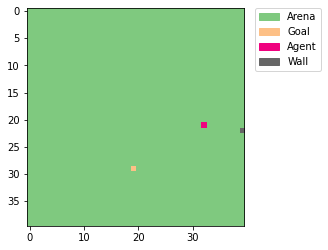

In [19]:
visualize(env.image_space)

In [13]:
my_config = matrix2arena(env.image_space)

In [14]:
trainer_config_path = (
    "../configurations/training_configurations/train_ml_agents_config_ppo_10fs.yaml"
)
reset_trainer(trainer_config_path)

In [15]:
reward = train_protagonist(arena_config=my_config, trainer_config_path=trainer_config_path, base_port_protagonist=6002, load_model=False)

Converting ./models/protagonist/AnimalAI/frozen_graph_def.pb to ./models/protagonist/AnimalAI.nn
GLOBALS: 'is_continuous_control', 'version_number', 'memory_size', 'action_output_shape'
IN: 'visual_observation_0': [-1, 84, 84, 3] => 'policy/main_graph_0_encoder0/conv_1/BiasAdd'
IN: 'vector_observation': [-1, 1, 1, 3] => 'policy/main_graph_0/hidden_0/BiasAdd'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice'
IN: 'action_masks': [-1, 1, 1, 6] => 'policy_1/strided_slice_1'
OUT: 'policy/concat/concat', 'action'
DONE: wrote ./models/protagonist/AnimalAI.nn file.
PROTAGONIST: 
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
Steps:  10000  Cumulative reward:  -0.9999999310821296  Episode Length:  248.0
